# Refactor

In [2]:
!pip install segyio
!pip install seaborn
!pip install obspy
!pip install las-converter
!pip install ibm2ieee
!pip install accessify

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Using cached https://files.pythonhosted.org/packages/f1/b9/7caef6d844143bf0383eb0513f5df212fe0bd5f50bd3b4a940043b868f35/accessify-0.3.1.tar.gz
  Running setup.py install for accessify: started
    Running setup.py install for accessify: finished with status 'done'


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import pylab as plt
import os
import sys
from sklearn.linear_model import LinearRegression
import seaborn as sns
from SeismicData import SeismicData

from time import time
from LAS import Converter
import pandas as pd

plt.style.use('seaborn-white')

ModuleNotFoundError: No module named 'SeismicData'

In [4]:
sgy_filename = 'w1_cdp.sgy'
start = time()
ss = s.Seg.SegReader()
ss.open(sgy_filename)
data, binary_header, head = ss.read_all()
dt = binary_header['Interval'] * 1e-6
sgy_data = data.T[:, head.index]

NameError: name 'time' is not defined

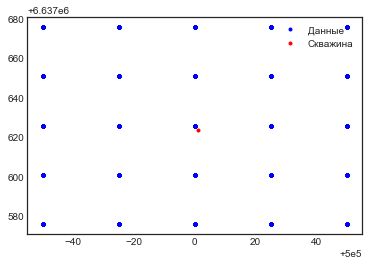

In [3]:
def extract_lasdata(filename, apply=None):
    las_converter = Converter()
    log = las_converter.set_file(filename)
    df = pd.DataFrame(log.data)
    if apply is None:
        return df
    return apply(df)
    
def extract_well_priory(well_priory): 
    well_priory = well_priory[(well_priory['rhob'] != -999.25) & (well_priory['dts'] != -999.25) & (well_priory['dt'] != -999.25)]
    well_priory['dts'] = 1 / well_priory['dts'].values
    well_priory['dt'] = 1 / well_priory['dt'].values
    well_priory = well_priory.rename(columns = {'dts':'Vs','dt':'Vp'})
    return well_priory
    
def extract_well_T(well_T):
    well_T['time'] = well_T['time'] * 1000
    return well_T

def find_nearest_observations(head, well_X, well_Y):
    head['well_X'] = well_X;
    head['well_Y'] = well_Y
    head['OFF'] = np.sqrt(((head[['CDP_X', 'CDP_Y']].values - head[['well_X', 'well_Y']].values) ** 2).sum(axis=1))
    return head, head[head['OFF']==head['OFF'].min()].index

def plot_wells(wells_dict):
    for w in wells_dict:
        plt.plot(w['x'], w['y'], w['clr'], label = w['label'])
    plt.legend()


las_path = ''
well_priory = extract_lasdata(las_path + 'Z-Zim-1jgw.las', extract_well_priory)
well_X, well_Y = 500001, 6637623.6
well_T = extract_lasdata(las_path + 'Z-Zim-1_TIME.las', extract_well_T)
head, indexies = find_nearest_observations(head, well_X, well_Y)


records = {'label': 'Данные', 'x': head['CDP_X'], 'y': head['CDP_Y'], 'clr':'b.'}
wells = {'label': 'Скважина', 'x': [well_X], 'y': [well_Y], 'clr':'r.'}
plot_wells([records, wells])

data = sgy_data[:,indexies]

# Range selector

In [4]:
import sys
from PyQt5.QtWidgets import QDialog, QApplication, QPushButton, QVBoxLayout, QLineEdit, QHBoxLayout, QLabel
from PyQt5 import QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
import random
from matplotlib.figure import Figure

%gui qt

class RangeSelector(QDialog):
    def __init__(self, image, app, parent=None):
        super(RangeSelector, self).__init__(parent)
        
        self.app = app
        self.image = image
        self.figure = Figure(figsize=(10, 20))
        
        self.canvas = FigureCanvas(self.figure)
        self.draw_plots()
        
        
        self.toolbar = NavigationToolbar(self.canvas, self)
        self.button = QPushButton('Finish')
        self.button.clicked.connect(self.on_result)
        
        self.text_top = QLabel('Top: ')
        self.top_value = QLineEdit('')
        
        self.text_down = QLabel('Down: ')
        self.down_value = QLineEdit()
        
        vbox_layout = QVBoxLayout()
        vbox_layout.addWidget(self.toolbar)
        vbox_layout.addWidget(self.canvas)
        
        hbox_layout = QHBoxLayout()
        hbox_layout.addWidget(self.button)
        hbox_layout.addWidget(self.text_top)
        hbox_layout.addWidget(self.top_value)
        hbox_layout.addWidget(self.text_down)
        hbox_layout.addWidget(self.down_value)
        
        vbox_layout.addLayout(hbox_layout)
        
        self.setLayout(vbox_layout)

        
        self.ymin, self.ymax = 0, 0
        self.result = None
        
    def on_result(self):
        ymax_text = self.top_value.text()
        ymin_text = self.down_value.text()
        
        if ymax_text.isdigit() and ymin_text.isdigit():
            min_y, max_y = int(ymin_text), int(ymax_text)
            self.result = (self.image[min_y:max_y, :], min_y, max_y)
            self.close()
            QtWidgets.QApplication.quit()
    
    def onselect(self, ymin, ymax):
        self.ymin, self.ymax = int(ymin), int(ymax)
        self.top_value.setText(str(self.ymax))
        self.down_value.setText(str(self.ymin))
        extent = [0, self.image.shape[1], ymin, ymax]
        self.sub_axs.imshow(self.image[self.ymin:self.ymax, :], cmap='seismic', extent=extent)
        self.canvas.draw()
        
    def draw_plots(self):
        self.figure.clear()
        self.range_axs = self.figure.add_subplot(121)
        self.sub_axs = self.figure.add_subplot(122)
        self.range_axs.imshow(self.image, aspect='auto', cmap='seismic')
        self.sub_axs.imshow(self.image, aspect='auto', cmap='seismic')
        self.span_selector = SpanSelector(self.range_axs, self.onselect, 'vertical', useblit=True,
            rectprops=dict(alpha=0.5, facecolor='gray'), span_stays=True)
        self.canvas.draw()
        
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
rangeSelector = RangeSelector(data, app)
rangeSelector.show()

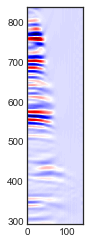

In [5]:
result, ymin, ymax = rangeSelector.result 
plt.imshow(result, cmap='seismic', extent=[0, result.shape[1], ymin, ymax])

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import HBox, Layout, interactive, widgets

image = data
max_value = image.shape[0]

def get_int_slider(name, max_value):
    layout = widgets.Layout(border='0px solid red',
                            height=str(max_value/3.5) + 'px', width='40px',
                            margin='30px 30px 0px 0px',padding='0px 0px 0px 0px')
    int_slider = widgets.IntSlider(
        value=max_value//2,
        min=0,
        max=max_value,
        step=1,
        description=name,
        layout=layout,
        orientation='vertical',
    )
    return int_slider

    
selected_data = None

def update(down, top):

    global selected_data
    """Remove old lines from plot and plot new one"""
    fig, (range_axs, crop_axs) = plt.subplots(1, 2, figsize=(7, 10))
    range_axs.imshow(image, cmap='seismic', aspect='auto')
    range_axs.axhline(y=down, color='lawngreen', linestyle='-', linewidth=3)
    range_axs.axhline(y=top, color='cyan', linestyle='-', linewidth=3)
    range_axs.set_ylim(0, image.shape[0])
    down, top =  (down, top) if down < top else (0, image.shape[0])
    to_show = image[down:top, :] 

    crop_axs.imshow(to_show, cmap='seismic', extent = [0, to_show.shape[1], down, top])
    crop_axs.set_ylim(down, top)
    selected_data = to_show
    plt.show()

w = interactive(update, down=get_int_slider('down', max_value), top=get_int_slider('top', max_value))

b = Layout(display='inline-flex', flex_flow='row', justify_content='flex-start', align_items='center')
display(HBox([w.children[0], w.children[1],  w.children[2]], layout=b))

# show 3d slice

In [7]:
from seislab.src import segyrw 
import sys
import numpy as np
import SegRead as s
from time import time

directory = ''
filename = directory+ '307_Stk_w1.sgy'
ss = s.Seg.SegReader()
ss.open(filename)
data = ss.get_data()
data = data.T
head = segyrw.read_header_segyio_full(filename)
dt = 2
Tdata = np.arange(0, np.shape(data)[0]*dt,dt) / 1000

In [8]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
%matplotlib inline


cdp_min, cdp_max, time_min, time_max = [head['CDP_TRACE'].min(), head['CDP_TRACE'].max(), 0, dt * data.shape[0]]
time_step = dt
cdp_step = (cdp_max - cdp_min) // data.shape[1]
(cdp_min, cdp_max, cdp_step),  (time_min, time_max, time_step)


@widgets.interact(cdp=(cdp_min, cdp_max, cdp_step), time=(time_min, time_max, time_step))
def interactive_traces(cdp, time):
    fig, axs = plt.subplots(figsize = (14,8))
    axs.set_xlabel('CDP')
    axs.set_ylabel('T, ms')    
    time_top = time//time_step
    cdp_top = (cdp - cdp_min)//cdp_step
    if time_top != 0 and cdp_top != 0:
        im = axs.imshow(data[:time_top, :cdp_top], cmap='seismic', aspect='auto', 
                    extent = [head['CDP_TRACE'].min(), cdp, time, 0]
                    )
        fig.colorbar(im, ax=axs)

interactive(children=(IntSlider(value=42036, description='cdp', max=58016, min=26196, step=72), IntSlider(valu…

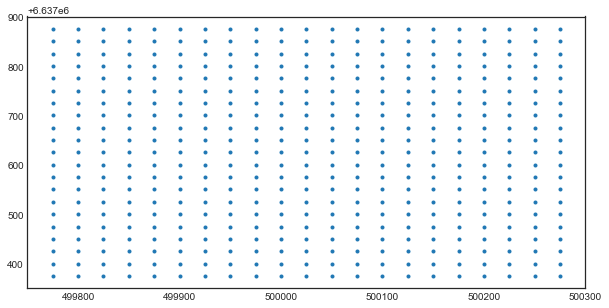

In [9]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(head['CDP_X'],head['CDP_Y'],linewidth = 0,marker='.')

In [10]:
xline_size = head['XLINE'].values.max() - head['XLINE'].values.min()
yline_size = head['INLINE'].values.max() - head['INLINE'].values.min()
data_cube = data.reshape((data.shape[0], xline_size + 1, yline_size + 1))
data_cube.shape

(2001, 21, 21)

In [11]:
from matplotlib.pyplot import draw
import matplotlib.pyplot as plt

def get_int_slider(name, max_value):
    layout = widgets.Layout(border='0px solid red', width='700px',
                            margin='30px 30px 0px 0px',padding='0px 0px 0px 0px')
    int_slider = widgets.IntSlider(
        value=max_value//2,
        min=0,
        max=max_value,
        step=1,
        description=name,
        layout=layout,
        orientation='horizontal',
    )
    return int_slider

def explore_cube(data_cube, head):
    times, inlines_count, xlines_count = data_cube.shape
    inline_min = head['INLINE'].min()
    xline_min = head['XLINE'].min()

    tw = widgets.ToggleButtons(
        options=['INLINE', 'XLINE', 'TIME'],
        description='DIM:',
        disabled=False,
        button_style='', 
    )
    @widgets.interact(inline=get_int_slider('inline', inlines_count - 1),
                      xline=get_int_slider('xline', xlines_count - 1), time=get_int_slider('time', times - 1), w = tw)
    def show_cube(inline, xline, time, w):
        
        figsize = (8,8)
        aspect='auto'
        if w == 'INLINE':
            sub_head = head[head[w] == inline_min + inline] 
            to_show = data_cube[:, :, inline]
        elif w == 'XLINE':
            sub_head = head[head[w] == xline_min + xline] 
            to_show = data_cube[:, xline, :]
        else:
            to_show = data_cube[time, :, :]
            sub_head = head
            aspect, figsize = None, (8, 8)
            
        fig, axs = plt.subplots(1, 2, figsize = figsize, gridspec_kw={'width_ratios': [1, 3]})
        cdp_x_active = sub_head['CDP_X']
        cdp_y_active = sub_head['CDP_Y']
        axs[0].imshow(to_show, cmap='seismic', aspect=aspect, interpolation='None')
        axs[1].plot(head['CDP_X'], head['CDP_Y'], 'b.')
        axs[1].plot(cdp_x_active, cdp_y_active, 'r*')
        plt.show()
    return show_cube

explore_cube(data_cube, head)

interactive(children=(IntSlider(value=10, description='inline', layout=Layout(border='0px solid red', margin='…

<function __main__.explore_cube.<locals>.show_cube(inline, xline, time, w)>

In [12]:
import sys
from PyQt5.QtWidgets import QDialog, QApplication, QPushButton, QVBoxLayout, QLineEdit, QHBoxLayout, QLabel, QSlider, QComboBox
from PyQt5 import QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
import random
from matplotlib.figure import Figure
from PyQt5.QtCore import Qt
%gui qt



class SliceViewer(QDialog):
    
    def __init__(self, volume, parent=None):
        super(SliceViewer, self).__init__(parent)
        
        self.volume = volume
        self.time_size, self.inline_size, self.xline_size = self.volume.shape
        
        self.figure = Figure(figsize=(4, 15))
        self.canvas = FigureCanvas(self.figure)
        
        
        self.toolbar = NavigationToolbar(self.canvas, self)
        
        
        self.control_vbox = QVBoxLayout()
        self.slider = QSlider()
        self.slider.valueChanged[int].connect(self.change_value)
        
        self.slider.setOrientation(Qt.Vertical)
        self.slider.setTickPosition(QSlider.TicksBelow)
        self.slider.setTickInterval(1)
        self.slider.setMinimum(0)
        self.slider.setMaximum(self.inline_size)
        
        
        self.combo = QComboBox(self)
        self.combo.addItem("INLINE")
        self.combo.addItem("XLINE")
        self.combo.addItem("TIME")
        self.combo.activated[str].connect(self.combo_changed)  
        self.slider_value_label = QLabel('') 
        
        self.control_vbox.addWidget(self.slider_value_label)
        self.control_vbox.addWidget(self.slider)
                
        
        self.mpl_vbox = QVBoxLayout()
        self.mpl_vbox.addWidget(self.canvas)
        self.mpl_vbox.addWidget(self.combo)
        self.mpl_vbox.addWidget(self.toolbar)
        
        
        
        self.hbox_layout = QHBoxLayout()
        self.hbox_layout.addLayout(self.mpl_vbox)
        self.hbox_layout.addLayout(self.control_vbox)
        
        self.combo_changed('INLINE')
        self.setLayout(self.hbox_layout)
        
        
    def change_value(self, value):
        self.slider_value_label.setText(str(value))
        self.show_slice()
        
    def combo_changed(self, text):
        if text =='INLINE':
            self.show_type = 'INLINE'
            self.slider.setMaximum(self.inline_size)
            self.slider.setValue(self.inline_size//2)
        elif text == 'XLINE':
            self.show_type = 'XLINE'
            self.slider.setMaximum(self.xline_size)
            self.slider.setValue(self.xline_size//2)
        else:
            self.show_type = 'TIME'
            self.slider.setMaximum(self.time_size)
            self.slider.setValue(self.time_size//2)
        self.show_slice()
            
        
    def show_slice(self):
        self.figure.clear()
        if self.show_type == 'INLINE':
            to_show = self.volume[:, :, self.slider.value()]
        elif self.show_type == 'XLINE':
            to_show = self.volume[:, self.slider.value(), :]
        else:
            to_show = self.volume[self.slider.value(), :, :]
            
        self.slice_axs = self.figure.add_subplot(111)
        self.slice_axs.imshow(to_show, aspect='auto', cmap='seismic')
        self.canvas.draw()
                  
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
sliceViewwer = SliceViewer(data_cube)
sliceViewwer.show()